## Notebook for analysis of DAMGO ramping experiments

### Import necessary packages

In [1]:
%matplotlib notebook
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
import re
import io
import os
import sys 
sys.path.append('..')
from brian2 import *
import brian_utils.postproc as bup
from scipy import stats
from scipy.optimize import curve_fit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d
import statsmodels.api as sm
from statsmodels.formula.api import *
from statsmodels import *
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pickle
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"


### Load data

In [3]:
df = pd.read_csv('damgo_ramp.csv')
df = df.drop(columns=['Unnamed: 0'])
features = df.iloc[:, 1:82].columns
df.head()

,run_seed,oprm1_T_oprm1_T,oprm1_T_oprm1_B,oprm1_T_oprm1_Q,oprm1_B_oprm1_T,oprm1_B_oprm1_B,oprm1_B_oprm1_Q,oprm1_Q_oprm1_T,oprm1_Q_oprm1_B,oprm1_Q_oprm1_Q,...,inh_T_inh_Q,inh_B_inh_T,inh_B_inh_B,inh_B_inh_Q,inh_Q_inh_T,inh_Q_inh_B,inh_Q_inh_Q,I_opioid_shutdown,LD50,E_E_connectivity
0,1,37,1,27,2,0,2,31,6,21,...,2,0,0,1,2,4,31,5.400000,3.650711,0.250892
1,2,31,12,28,8,2,1,33,2,28,...,2,0,2,1,4,4,15,5.060000,2.616641,0.054963
2,3,43,1,45,3,1,2,37,5,37,...,3,0,0,2,0,3,27,5.366667,3.854999,0.162036
3,4,25,3,22,4,1,9,38,6,51,...,3,0,0,1,1,4,24,4.793333,2.627077,0.156518
4,5,38,9,24,10,2,6,35,8,26,...,5,0,0,1,2,1,28,4.573333,3.178506,0.052165


In [4]:
features # every type of connection

Index(['oprm1_T_oprm1_T', 'oprm1_T_oprm1_B', 'oprm1_T_oprm1_Q',
       'oprm1_B_oprm1_T', 'oprm1_B_oprm1_B', 'oprm1_B_oprm1_Q',
       'oprm1_Q_oprm1_T', 'oprm1_Q_oprm1_B', 'oprm1_Q_oprm1_Q',
       'exc_T_oprm1_T', 'exc_T_oprm1_B', 'exc_T_oprm1_Q', 'exc_B_oprm1_T',
       'exc_B_oprm1_B', 'exc_B_oprm1_Q', 'exc_Q_oprm1_T', 'exc_Q_oprm1_B',
       'exc_Q_oprm1_Q', 'inh_T_oprm1_T', 'inh_T_oprm1_B', 'inh_T_oprm1_Q',
       'inh_B_oprm1_T', 'inh_B_oprm1_B', 'inh_B_oprm1_Q', 'inh_Q_oprm1_T',
       'inh_Q_oprm1_B', 'inh_Q_oprm1_Q', 'oprm1_T_exc_T', 'oprm1_T_exc_B',
       'oprm1_T_exc_Q', 'oprm1_B_exc_T', 'oprm1_B_exc_B', 'oprm1_B_exc_Q',
       'oprm1_Q_exc_T', 'oprm1_Q_exc_B', 'oprm1_Q_exc_Q', 'oprm1_T_inh_T',
       'oprm1_T_inh_B', 'oprm1_T_inh_Q', 'oprm1_B_inh_T', 'oprm1_B_inh_B',
       'oprm1_B_inh_Q', 'oprm1_Q_inh_T', 'oprm1_Q_inh_B', 'oprm1_Q_inh_Q',
       'exc_T_exc_T', 'exc_T_exc_B', 'exc_T_exc_Q', 'exc_B_exc_T',
       'exc_B_exc_B', 'exc_B_exc_Q', 'exc_Q_exc_T', 'exc_Q_exc_B',

### Exploratory data analysis

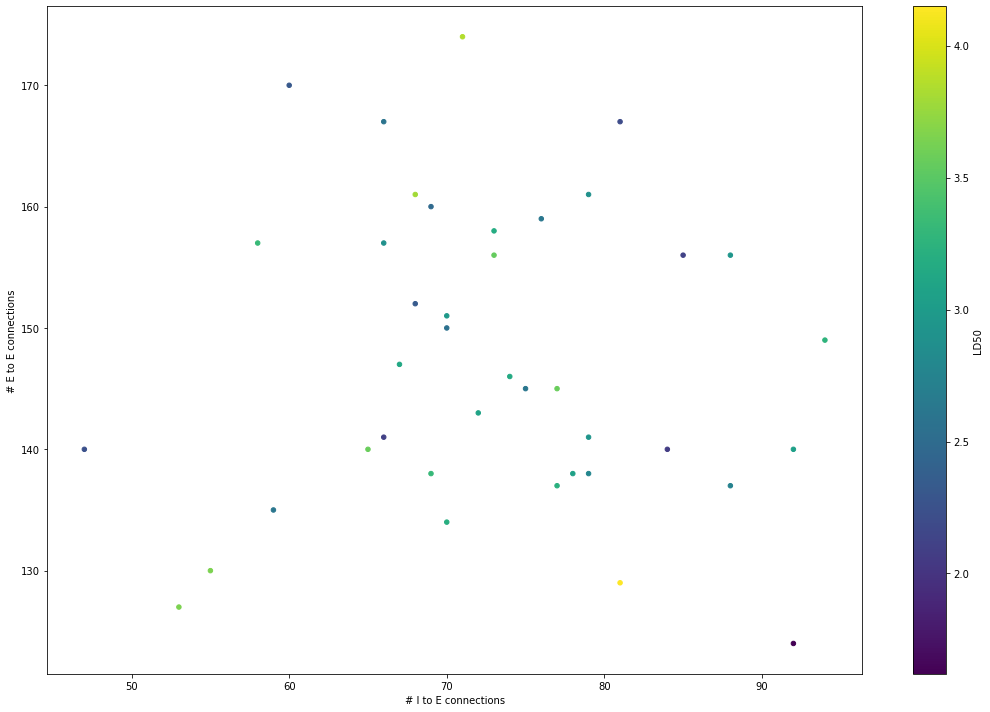

In [6]:
df['oprm1_oprm1'] = df.iloc[:, 1:10].sum(axis=1)
df['inh_oprm1'] = df.iloc[:, 19:28].sum(axis=1)

ax=df.plot('inh_oprm1','oprm1_oprm1',kind='scatter', c='LD50',colormap=mpl.cm.viridis, colorbar=True, figsize=(15,10),sharex=False)
ax.set_xlabel('# I to E connections')
ax.set_ylabel('# E to E connections')
plt.tight_layout()

In [42]:
df['I_opioid_shutdown']

0     5.400000
1     5.060000
2     5.366667
3     4.793333
4     4.573333
5     6.340000
6     5.093333
7     4.433333
8     5.160000
9     4.240000
10    5.120000
11    5.240000
12    6.486667
13    5.086667
14    4.746667
15    5.366667
16    4.746667
17    5.180000
18    5.546667
19    3.733333
20    5.466667
21    5.706667
22    3.886667
23    5.260000
24    5.686667
25    5.333333
26    5.020000
27    6.160000
28    5.040000
29    5.800000
30    6.033333
31    7.506667
32    4.653333
33    5.373333
34    5.286667
35    5.300000
36    5.826667
37    4.866667
38    5.553333
39    4.940000
Name: I_opioid_shutdown, dtype: float64

### PCA

In [62]:
from pca import pca
X = df.loc[:, features2].values
pca = pca(n_components=len(features2))
results = pca.fit_transform(X)
results.keys()

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [25] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[25]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


dict_keys(['loadings', 'PC', 'explained_var', 'model', 'scaler', 'pcp', 'topfeat', 'outliers', 'outliers_params'])

In [98]:
# Principal components: eigenvectors of the covariance matrix
results['PC'] = results['PC'].reset_index()
results['PC'] = results['PC'].drop(columns='index')
results['PC']

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40
0,23.541537,13.827011,4.782520,-11.569180,1.922612,-9.548911,-3.615459,4.090967,10.028457,-4.321594,...,1.594242,-0.719646,1.214320,-0.598289,-0.298827,0.443415,-0.069147,0.167210,-0.566755,-6.128006e-16
1,-2.156763,15.343501,-21.740813,-21.364277,-15.350421,-1.444949,2.553587,-2.672732,-0.607173,2.070490,...,1.392157,1.111184,0.970614,0.562703,-1.169923,-2.950742,1.923233,-0.419778,0.524460,-6.108405e-15
2,-2.598508,13.128205,-2.147819,23.043204,-10.580184,-1.404835,-8.256087,-2.345000,-0.881192,-4.499163,...,0.234783,-1.452880,-0.972691,-0.549856,0.925692,0.681354,0.775031,0.829561,-1.801592,8.443672e-16
3,-4.370678,-20.747287,1.579793,5.697152,-11.609569,0.886393,12.046817,4.604516,8.486652,-6.988885,...,-3.036148,-0.169029,-1.773929,1.070450,-0.590501,-0.931393,-0.322068,2.251971,0.940265,7.713872e-15
4,18.774305,-6.245949,-5.477749,4.629972,-6.252994,10.435541,16.641503,18.755401,-12.702905,-7.233140,...,1.211261,0.451570,-1.242580,-0.028210,-0.931608,0.019236,-0.080356,-1.073938,1.012233,3.619925e-15
5,-2.960805,23.162325,7.307559,-5.941112,-8.532515,-7.108005,-2.235750,-0.941707,0.013668,-9.744458,...,-0.872452,1.356698,3.582136,0.536072,0.423596,-0.145497,-0.475509,-1.739859,0.051709,2.198667e-16
6,-8.330295,-14.317752,-5.798793,-8.096699,0.530384,-4.145538,-5.956224,10.791335,9.377050,-6.951042,...,0.625122,1.745734,0.294286,0.498301,-0.839653,1.469658,-2.188461,1.725133,0.432120,5.548937e-15
7,-18.881935,-24.542329,-0.688895,4.911492,-13.917891,10.106080,-6.985993,-1.318842,2.465261,-2.973241,...,-0.387525,-1.267062,1.867203,-0.500140,-0.898849,-1.241333,-0.413321,-1.654096,-0.756236,4.660759e-15
8,1.188237,-20.459687,5.554013,-9.988648,-13.196084,4.039251,-4.347283,-5.186882,-10.853177,3.068836,...,-2.177653,-0.793717,-0.761753,-3.660949,1.539742,0.280269,-0.578413,-1.288386,-0.364272,-2.797337e-16
9,0.706619,5.068701,-8.224097,6.968346,-3.166597,0.831708,-6.509270,9.725418,-2.440592,14.457628,...,-1.037042,-2.838523,0.392675,0.023761,-0.405840,-1.826229,1.843902,2.252317,0.746550,2.773380e-15


In [28]:
# Cumulative proportion of variance explained by each PC 
results['explained_var']

array([0.1798323 , 0.30558836, 0.38867302, 0.45615069, 0.52057118,
       0.56856363, 0.61252368, 0.65471474, 0.69185548, 0.72641582,
       0.75624405, 0.78280386, 0.8078814 , 0.83262952, 0.85540434,
       0.87423997, 0.89253322, 0.90860867, 0.92211705, 0.9329798 ,
       0.94278234, 0.95110772, 0.95875186, 0.96501649, 0.97014573,
       0.97429872, 0.97805014, 0.98159456, 0.9846559 , 0.98744256,
       0.98976356, 0.9917124 , 0.99347775, 0.99515733, 0.996376  ,
       0.99754181, 0.99850163, 0.9993719 , 1.        , 1.        ])

In [84]:
loadings = results['loadings'].T
loadings['connection type'] = features2
pd.set_option('display.max_rows', 25)
loadings = loadings.set_index('connection type')
loadings.sort_values('PC1')

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25
connection type,,,,,,,,,,,,,,,,,,,,,,,,,
inh_Q_oprm1_Q,-0.283487,0.092639,-0.298055,-0.274459,-0.128399,0.273728,-0.221120,0.039080,-0.403439,0.167210,0.148362,0.170910,0.227856,-0.261771,0.130281,0.119159,0.060540,0.209882,0.199725,-0.010218,0.254429,0.033536,-0.171279,0.168383,0.015399
oprm1_Q_oprm1_Q,-0.268669,0.352028,-0.250742,0.324540,-0.430349,-0.107621,0.128869,-0.159822,0.071759,0.182392,-0.271636,0.005222,0.102162,-0.071173,-0.023639,-0.123165,0.031194,0.251594,-0.156015,-0.074810,-0.326170,0.002518,-0.112276,-0.196163,0.040171
exc_Q_oprm1_Q,-0.224332,0.008740,-0.123815,0.101679,-0.184033,-0.048147,-0.087143,0.245237,0.199485,-0.052645,0.090376,-0.486770,0.018288,-0.209109,0.113159,0.088173,0.373498,-0.339981,-0.056967,0.228495,0.243084,0.083453,0.133372,-0.123797,0.240789
exc_Q_exc_Q,-0.209459,-0.301555,0.134096,-0.297822,-0.312459,-0.227773,0.289495,0.322005,-0.135331,0.122584,-0.100027,0.090301,0.142285,0.359897,0.041294,-0.203704,0.174161,-0.048563,0.104729,0.192890,-0.066691,0.154612,-0.031986,-0.021314,-0.257564
inh_Q_exc_Q,-0.187270,-0.068612,-0.324929,-0.094777,0.115526,0.067489,0.323374,-0.156591,0.118541,0.031618,0.158346,-0.030885,-0.010548,-0.048152,-0.364904,-0.258454,-0.275109,0.054724,0.212193,0.388360,-0.043078,-0.010660,0.320547,0.156400,0.226928
oprm1_Q_exc_Q,-0.155795,0.024436,-0.202360,0.024922,0.047797,0.061805,0.107789,0.107746,0.183736,-0.380608,-0.200127,0.133444,0.286732,0.182037,0.106432,-0.165244,-0.165770,-0.068868,0.007924,-0.144606,0.423693,-0.484680,-0.037062,-0.199926,-0.069219
exc_Q_inh_Q,-0.108632,-0.358597,-0.246983,-0.137912,0.120101,-0.052985,-0.128087,-0.124160,-0.209915,0.149584,0.010847,0.130960,0.083302,-0.077137,-0.141114,-0.088788,0.210608,-0.389534,-0.178608,-0.377119,-0.314229,-0.231439,0.186455,-0.167682,0.144016
inh_Q_inh_Q,-0.085000,-0.044392,-0.189529,0.178788,0.298376,-0.209428,-0.342012,0.078376,-0.024228,-0.176009,0.209974,-0.206886,0.267914,0.270993,-0.273194,-0.209807,0.024539,0.079283,0.009070,0.025401,-0.114350,0.207455,-0.468520,0.035340,0.009934
inh_Q_oprm1_T,-0.055410,-0.058988,-0.225434,-0.154811,0.036046,0.485842,0.226077,0.305384,0.216404,0.055440,-0.040867,0.067806,-0.315135,0.182736,-0.149629,0.142385,-0.045364,-0.027444,-0.273761,-0.186822,-0.006860,0.261260,-0.300165,-0.090257,0.161885


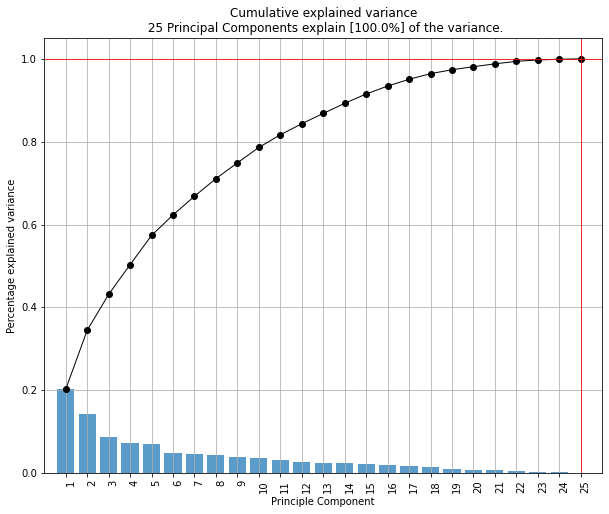

(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Cumulative explained variance\n 25 Principal Components explain [100.0%] of the variance.'}, xlabel='Principle Component', ylabel='Percentage explained variance'>)

<Figure size 432x288 with 0 Axes>

In [66]:
pca.plot()

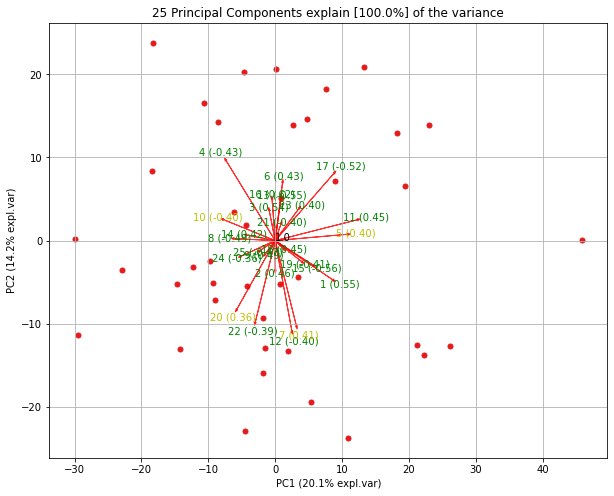

(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'25 Principal Components explain [100.0%] of the variance'}, xlabel='PC1 (20.1% expl.var)', ylabel='PC2 (14.2% expl.var)'>)

In [67]:
pca.biplot(n_feat=25,legend=False)

### Correlations between connection types and shutdown dosage

In [7]:
df[features].head()

,oprm1_T_oprm1_T,oprm1_T_oprm1_B,oprm1_T_oprm1_Q,oprm1_B_oprm1_T,oprm1_B_oprm1_B,oprm1_B_oprm1_Q,oprm1_Q_oprm1_T,oprm1_Q_oprm1_B,oprm1_Q_oprm1_Q,exc_T_oprm1_T,...,inh_Q_exc_Q,inh_T_inh_T,inh_T_inh_B,inh_T_inh_Q,inh_B_inh_T,inh_B_inh_B,inh_B_inh_Q,inh_Q_inh_T,inh_Q_inh_B,inh_Q_inh_Q
0,37,1,27,2,0,2,31,6,21,43,...,31,0,0,2,0,0,1,2,4,31
1,31,12,28,8,2,1,33,2,28,31,...,20,0,0,2,0,2,1,4,4,15
2,43,1,45,3,1,2,37,5,37,41,...,28,0,1,3,0,0,2,0,3,27
3,25,3,22,4,1,9,38,6,51,39,...,22,0,0,3,0,0,1,1,4,24
4,38,9,24,10,2,6,35,8,26,56,...,20,0,0,5,0,0,1,2,1,28


In [8]:
pd.set_option('display.max_columns', 81)
corr = df.iloc[:,1:83].corr()
corr.iloc[:, 81:82].T.drop(columns='I_opioid_shutdown')

,oprm1_T_oprm1_T,oprm1_T_oprm1_B,oprm1_T_oprm1_Q,oprm1_B_oprm1_T,oprm1_B_oprm1_B,oprm1_B_oprm1_Q,oprm1_Q_oprm1_T,oprm1_Q_oprm1_B,oprm1_Q_oprm1_Q,exc_T_oprm1_T,exc_T_oprm1_B,exc_T_oprm1_Q,exc_B_oprm1_T,exc_B_oprm1_B,exc_B_oprm1_Q,exc_Q_oprm1_T,exc_Q_oprm1_B,exc_Q_oprm1_Q,inh_T_oprm1_T,inh_T_oprm1_B,inh_T_oprm1_Q,inh_B_oprm1_T,inh_B_oprm1_B,inh_B_oprm1_Q,inh_Q_oprm1_T,inh_Q_oprm1_B,inh_Q_oprm1_Q,oprm1_T_exc_T,oprm1_T_exc_B,oprm1_T_exc_Q,oprm1_B_exc_T,oprm1_B_exc_B,oprm1_B_exc_Q,oprm1_Q_exc_T,oprm1_Q_exc_B,oprm1_Q_exc_Q,oprm1_T_inh_T,oprm1_T_inh_B,oprm1_T_inh_Q,oprm1_B_inh_T,oprm1_B_inh_B,oprm1_B_inh_Q,oprm1_Q_inh_T,oprm1_Q_inh_B,oprm1_Q_inh_Q,exc_T_exc_T,exc_T_exc_B,exc_T_exc_Q,exc_B_exc_T,exc_B_exc_B,exc_B_exc_Q,exc_Q_exc_T,exc_Q_exc_B,exc_Q_exc_Q,exc_T_inh_T,exc_T_inh_B,exc_T_inh_Q,exc_B_inh_T,exc_B_inh_B,exc_B_inh_Q,exc_Q_inh_T,exc_Q_inh_B,exc_Q_inh_Q,inh_T_exc_T,inh_T_exc_B,inh_T_exc_Q,inh_B_exc_T,inh_B_exc_B,inh_B_exc_Q,inh_Q_exc_T,inh_Q_exc_B,inh_Q_exc_Q,inh_T_inh_T,inh_T_inh_B,inh_T_inh_Q,inh_B_inh_T,inh_B_inh_B,inh_B_inh_Q,inh_Q_inh_T,inh_Q_inh_B,inh_Q_inh_Q
I_opioid_shutdown,0.44325,-0.083674,0.106956,-0.222774,0.057316,-0.105555,-0.12199,-0.173451,-0.348005,0.135009,0.114707,-0.166045,-0.219885,0.192393,0.002188,0.295938,0.187183,0.046478,-0.047889,-0.131296,-0.182561,-0.212674,0.199241,-0.215794,0.22104,-0.130356,-0.30411,0.370109,0.023913,0.379583,-0.21144,-0.21606,-0.34324,-0.182546,-0.212642,-0.038725,-0.073433,-0.046826,0.158446,0.000603,-0.026049,-0.291411,-0.112596,-0.169273,0.130593,0.266355,-0.085755,0.298751,-0.057536,-0.096854,0.153825,0.478706,-0.202845,0.076475,-0.114134,0.07115,-0.07641,0.037132,-0.157569,-0.269848,-0.054491,-0.367521,0.001465,-0.123815,0.076861,-0.19849,0.055879,-0.209958,-0.218542,-0.290715,-0.137796,-0.057748,0.383239,-0.019842,-0.223419,NaN,0.047525,-0.098267,0.049972,-0.079302,-0.00415


### LASSO regression

In [7]:
y = df['I_opioid_shutdown'].values
X = df[features].values
X = preprocessing.StandardScaler().fit_transform(X)

model = LassoCV(alphas=np.logspace(-2,10,20),normalize=True).fit(X,y)
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=3)
scores = cross_val_score(model,X,y,scoring='neg_root_mean_squared_error',cv=cv)

print('RMSE: %.4f (%.4f)' % (-mean(scores), std(scores)))
print(r'λ = ' + str(model.alpha_))
print('R2: '+ str(model.score(X,y)))

pd.set_option('display.max_rows',81)
lasso_coef = pd.DataFrame(zip(features, model.coef_)).sort_values(1)
lasso_coef.columns = ['connection type', 'coefficient']
nonzero_lasso_coef = lasso_coef[lasso_coef['coefficient'] != 0]
nonzero_lasso_coef

RMSE: 0.7326 (0.2350)
λ = 0.01
R2: 0.7852087946992369


,connection type,coefficient
69,inh_Q_exc_T,-0.100384
32,oprm1_B_exc_Q,-0.068809
26,inh_Q_oprm1_Q,-0.059796
65,inh_T_exc_Q,-0.055752
8,oprm1_Q_oprm1_Q,-0.047484
12,exc_B_oprm1_T,-0.035955
41,oprm1_B_inh_Q,-0.018442
55,exc_T_inh_B,0.009051
45,exc_T_exc_T,0.009813
4,oprm1_B_oprm1_B,0.019945


### Ridge regression

In [8]:
y = df['I_opioid_shutdown'].values
X = df[features].values
X = preprocessing.StandardScaler().fit_transform(X)

model = RidgeCV(alphas=np.logspace(-2,10,20)).fit(X, y)
cv = RepeatedKFold(n_splits=5, n_repeats=10,random_state=1)
scores = cross_val_score(model,X,y,scoring='neg_root_mean_squared_error',cv=cv)

print('RMSE: %.4f (%.4f)' % (-mean(scores), std(scores)))
print(r'λ = ' + str(model.alpha_))
print('R2: '+ str(model.score(X,y)))

pd.set_option('display.max_rows',81)
ridge_coef = pd.DataFrame(zip(features, model.coef_)).sort_values(1)
ridge_coef.columns = ['connection type', 'coefficient']
ridge_coef.head()
ridge_coef.tail()

RMSE: 0.6562 (0.1868)
λ = 0.01
R2: 0.9999999462170781


,connection type,coefficient
50,exc_B_exc_Q,0.089755
16,exc_Q_oprm1_B,0.098088
22,inh_B_oprm1_B,0.105962
72,inh_T_inh_T,0.163083
51,exc_Q_exc_T,0.202908


### Elastic net regression

In [9]:
y = df['I_opioid_shutdown'].values
X = df[features].values
X = preprocessing.StandardScaler().fit_transform(X)

model = ElasticNetCV(alphas=np.logspace(-2,10,20)).fit(X, y)
cv = RepeatedKFold(n_splits=5, n_repeats=10,random_state=1)
scores = cross_val_score(model,X,y,scoring='neg_root_mean_squared_error',cv=cv)

print('RMSE: %.4f (%.4f)' % (-mean(scores), std(scores)))
print(r'λ = ' + str(model.alpha_))
print('R2: '+ str(model.score(X,y)))

pd.set_option('display.max_rows',81)
elastic_net_coef = pd.DataFrame(zip(features, model.coef_)).sort_values(1)
elastic_net_coef.columns = ['connection type', 'coefficient']
elastic_net_coef.head()
elastic_net_coef.tail()

RMSE: 0.7211 (0.2184)
λ = 0.18329807108324356
R2: 0.6387935767322828


,connection type,coefficient
29,oprm1_T_exc_Q,0.048753
0,oprm1_T_oprm1_T,0.071799
72,inh_T_inh_T,0.073161
22,inh_B_oprm1_B,0.086873
51,exc_Q_exc_T,0.174512


### OLS Regression

In [10]:
y = df['I_opioid_shutdown'].values
X = df[features].values
X = preprocessing.StandardScaler().fit_transform(X)

#X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.025, random_state=4)
model = LinearRegression().fit(X, y)
cv = RepeatedKFold(n_splits=5, n_repeats=10,random_state=1)
scores = cross_val_score(model,X,y,scoring='neg_root_mean_squared_error',cv=cv)
print('RMSE: %.4f (%.4f)' % (-mean(scores), std(scores)))
# pred = model.predict(X_test)
# print("MSE: " + str(mean_squared_error(y_test, pred)))
#print(r'λ = ' + str(model.alpha_))
print('R2: '+ str(model.score(X,y)))
pd.set_option('display.max_rows',81)
ols_coef = pd.DataFrame(zip(features, model.coef_)).sort_values(1)
ols_coef.columns = ['connection type', 'coefficient']
ols_coef.head()
ols_coef.tail()

RMSE: 0.6162 (0.1466)
R2: 1.0


,connection type,coefficient
50,exc_B_exc_Q,0.089673
16,exc_Q_oprm1_B,0.100964
22,inh_B_oprm1_B,0.103861
72,inh_T_inh_T,0.163575
51,exc_Q_exc_T,0.204053
